# 로지스틱 회귀 - 이항분류

분류는 분석보다 더 많은 데이터를 요구하는 경향이 있음

분석 - negative 요소 확인, 분류 - positive 요소 확인

## #01. 패키지 및 그래프 설정

In [1]:
import sys
sys.path.append("../../")
import helper

from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 데이터셋 준비

방사선학 석사과정 대학원생 모집을 하였다. 이 때 지원한 방사선사의 대학원 합격 여부에 따른 주요 요인이 무엇인지 분석하라.

단, 독립변수는 정규분포를 따른다고 가정한다.

| 변수 | 구분 | 설명 |
|---|---|---
| 합격여부 | 범주형 | 1=합격, 0=불합격 |
| 필기점수 | 연속형 | 800점 만점 |
| 학부성적 | 연속형 | 4.0 만점 |
| 병원경력 | 범주형 | 1: 10년이상, 2: 2~5년, 3: 1~5년, 4: 1년 미만 |

In [3]:
origin = read_excel("https://data.hossam.kr/E05/gradeuate.xlsx")
origin.head()

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## #03. 데이터 전처리

### 결측치 확인

isna

In [4]:
origin.isna().sum()

합격여부    0
필기점수    0
학부성적    0
병원경력    0
dtype: int64

### 명목형에 대한 데이터 타입 설정

- 명목형으로 의심되면 일단 value_counts()로 확인
- type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능

In [5]:
origin.columns

Index(['합격여부', '필기점수', '학부성적', '병원경력'], dtype='object')

In [6]:
# origin['병원경력'].value_counts()
origin['합격여부'].value_counts()

합격여부
0    273
1    127
Name: count, dtype: int64

In [7]:
origin['합격여부'] = origin['합격여부'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   합격여부    400 non-null    category
 1   필기점수    400 non-null    int64   
 2   학부성적    400 non-null    float64 
 3   병원경력    400 non-null    int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 10.0 KB


## #04. 탐색적 데이터 분석

### 기본(기초)통계 확인

describe

In [8]:
origin.describe()

,필기점수,학부성적,병원경력
count,400.000000,400.000000,400.00000
mean,587.700000,3.389900,2.48500
std,115.516536,0.380567,0.94446
min,220.000000,2.260000,1.00000
25%,520.000000,3.130000,2.00000
50%,580.000000,3.395000,2.00000
75%,660.000000,3.670000,3.00000
max,800.000000,4.000000,4.00000


### boxplot

표준화 여부 결정에 도움.

각 변수의 분포가 너무 상이할 경우 표준화 진행.

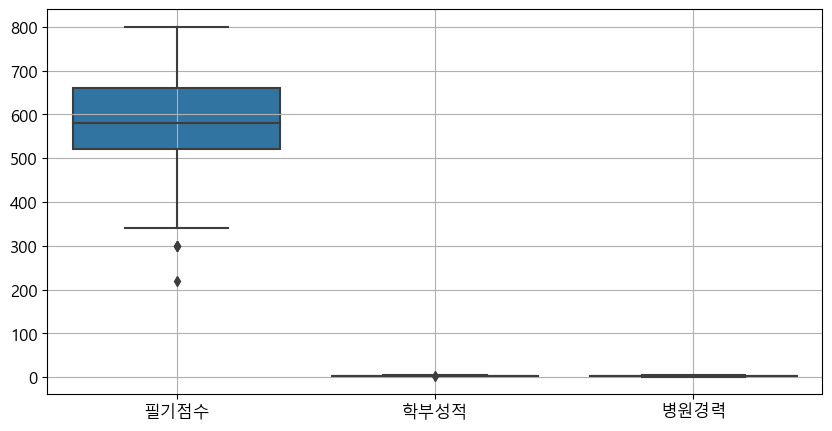

In [9]:
plt.figure()
sb.boxplot(data=origin)
plt.grid()
plt.show()
plt.close()

> 데이터 단위가 크게 상이하므로 표준화가 필요해 보임.

## #05. 데이터셋 분할

### 랜덤시드 고정

In [10]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [11]:
origin.columns

Index(['합격여부', '필기점수', '학부성적', '병원경력'], dtype='object')

In [12]:
x = origin[['필기점수','학부성적','병원경력']]
y = origin[['합격여부']]
x.shape, y.shape

((400, 3), (400, 1))

### 데이터 표준화

- 통계에서는 종속변수 표준화를 권장하지 않음
- 예측 값을 역 표준화 해야하지 때문
> - 단, 머신러닝 선능을 위해서 종속변수 표준화 권장
- 표준화를 거치면 numpy 배열 형태(2차원 데이터 배열) -> [0]로 열 길이 출력 가능
- 표준화를 진행하지 않으면 DF 형태(1차원 형태) -> iloc[0]로 열 길이 출력 가능
- type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능

In [13]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)
# type(x_scale.shape)
print(x_scale.shape)
x_scale

(400, 3)


array([[-1.80026271,  0.57907192,  0.54596793],
       [ 0.62666824,  0.73692942,  0.54596793],
       [ 1.84013372,  1.60514289, -1.57429586],
       ...,
       [-1.10685387, -1.99925902, -0.51416397],
       [ 0.97337266,  0.68431046, -0.51416397],
       [ 0.10661161,  1.31573861,  0.54596793]])

> 2차원 배열

### 표준화 전 후 상자그림 비교

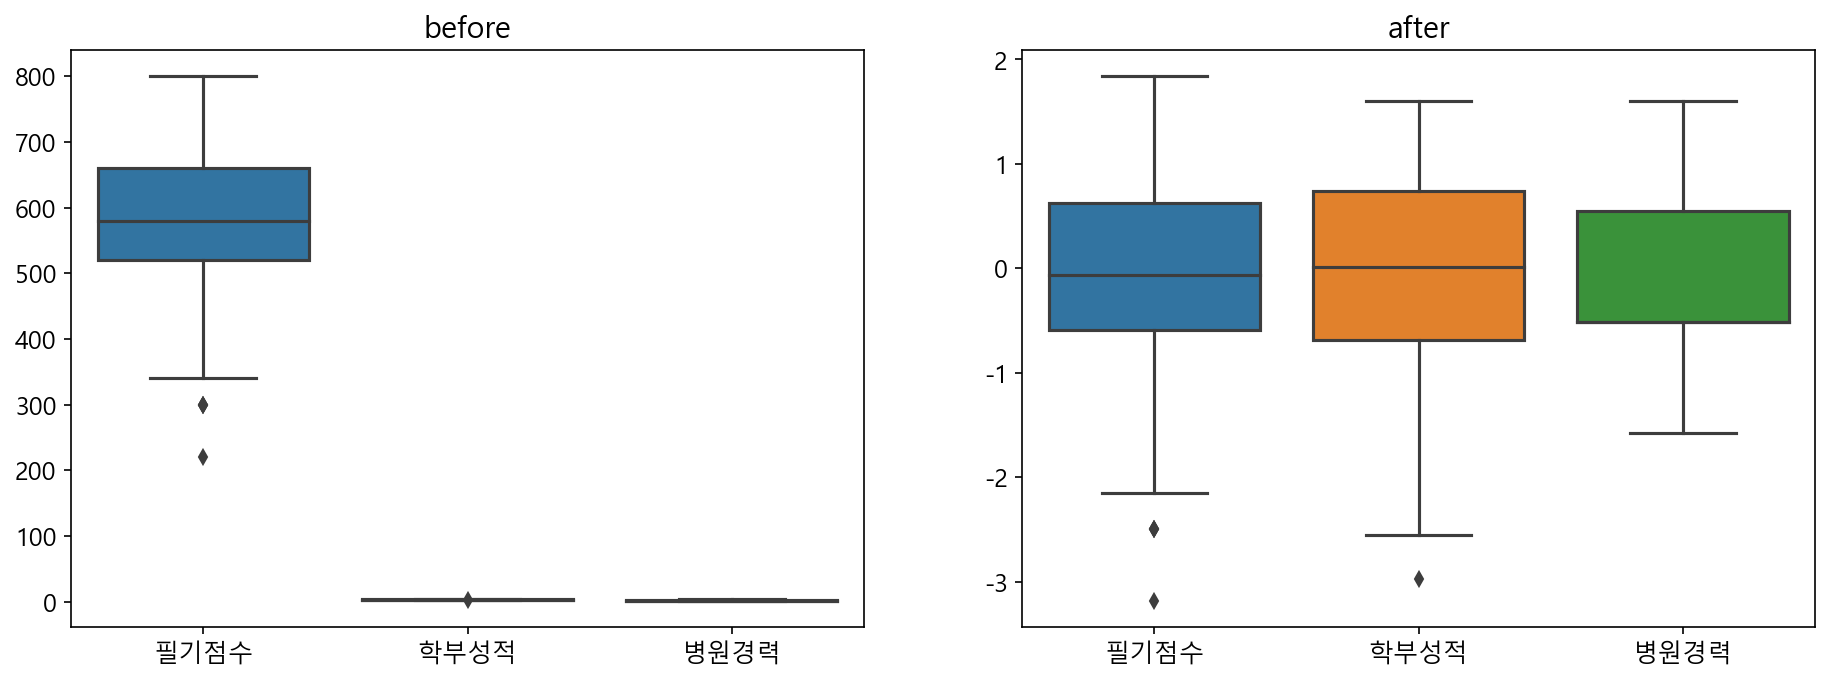

In [14]:
# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합
x_scale_df = DataFrame(x_scale, columns=['필기점수','학부성적','병원경력'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
sb.boxplot(data=origin, ax=ax[0])
sb.boxplot(data=x_scale_df, ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

> 데이터 분포가 개선되었음을 확인

### 훈련 데이터와 검증 데이터로 분할

In [15]:
# 종속변수 y는 표준화 미진행 -> y사용
x_train, x_test, y_train, y_test = train_test_split(x_scale, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((280, 3), (120, 3), (280, 1), (120, 1))

## #06. 모델 개발

### 모델 정의

> [relu], sigmoid, rmsporp, binary_crossentropy, acc

- input_shape은 독립변수 수
- Dense 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [16]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(3, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161 (644.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

- epochs는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 오차가 증가)
    - callback을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ReduceLROnPlateau EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ModelCheckpoint 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [17]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
9/9 [==============================] - 3s 83ms/step - loss: 0.7537 - acc: 0.4393 - val_loss: 0.7860 - val_acc: 0.4000 - lr: 0.0010
Epoch 2/500
9/9 [==============================] - 0s 15ms/step - loss: 0.7285 - acc: 0.4464 - val_loss: 0.7586 - val_acc: 0.4333 - lr: 0.0010
Epoch 3/500
9/9 [==============================] - 0s 33ms/step - loss: 0.7112 - acc: 0.4893 - val_loss: 0.7377 - val_acc: 0.4583 - lr: 0.0010
Epoch 4/500
9/9 [==============================] - 0s 14ms/step - loss: 0.6974 - acc: 0.5107 - val_loss: 0.7194 - val_acc: 0.4833 - lr: 0.0010
Epoch 5/500
9/9 [==============================] - 0s 19ms/step - loss: 0.6850 - acc: 0.5536 - val_loss: 0.7021 - val_acc: 0.5083 - lr: 0.0010
Epoch 6/500
9/9 [==============================] - 0s 17ms/step - loss: 0.6745 - acc: 0.5714 - val_loss: 0.6871 - val_acc: 0.5583 - lr: 0.0010
Epoch 7/500
9/9 [==============================] - 0s 19ms/step - loss: 0.6645 - acc: 0.6143 - val_loss: 0.6736 - val_acc: 0.6583 - lr: 0.0010

## #08. 학습 결과 적용

### 훈련 데이터에 대한 예측 결과 산정

> 데이터가 0하고 1일 경우 결과 값이 1일 확률

In [18]:
train_pred = model.predict(x_train)
data_count, case_count = train_pred.shape
print("%d개의 훈련 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(train_pred)

9/9 [==============================] - 0s 7ms/step
280개의 훈련 데이터가 1개의 경우의 수를 갖는다.
[[0.38484594]
 [0.53498065]
 [0.1372822 ]
 [0.2225482 ]
 [0.12923858]
 [0.1470468 ]
 [0.46153998]
 [0.5031493 ]
 [0.30865157]
 [0.3918956 ]
 [0.3050749 ]
 [0.37078637]
 [0.42849338]
 [0.279384  ]
 [0.1835221 ]
 [0.46143046]
 [0.22879544]
 [0.45174426]
 [0.5710997 ]
 [0.483962  ]
 [0.3336198 ]
 [0.5080202 ]
 [0.31932196]
 [0.14071338]
 [0.35477647]
 [0.37023795]
 [0.46279293]
 [0.32497403]
 [0.44914922]
 [0.46250325]
 [0.3436618 ]
 [0.4621363 ]
 [0.3367397 ]
 [0.22963569]
 [0.36711356]
 [0.25991452]
 [0.17375879]
 [0.09761123]
 [0.3349118 ]
 [0.42077637]
 [0.42267102]
 [0.1462435 ]
 [0.43838635]
 [0.31171733]
 [0.27557772]
 [0.44669437]
 [0.10441131]
 [0.28301638]
 [0.43595883]
 [0.15610664]
 [0.4422957 ]
 [0.3457702 ]
 [0.42272872]
 [0.16824791]
 [0.44792616]
 [0.51419395]
 [0.34614065]
 [0.4422957 ]
 [0.17735271]
 [0.29827127]
 [0.358682  ]
 [0.41515687]
 [0.27201608]
 [0.33369765]
 [0.20150949]
 [0.21784

### 검증 데이터에 대한 예측 결과 산정

In [20]:
test_pred = model.predict(x_test)
data_count, case_count = test_pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
# print(test_pred)

4/4 [==============================] - 0s 6ms/step
120개의 검증 데이터가 1개의 경우의 수를 갖는다.


### 결과 데이터 셋 구성

In [21]:
kdf = DataFrame({
    '결과값': y_train['합격여부'].values,
    '예측치' : np.round(train_pred.flatten()),
    '합격확률(%)': np.round(train_pred.flatten() * 100, 1)
})

kdf

,결과값,예측치,합격확률(%)
0,1,0.0,38.500000
1,1,1.0,53.500000
2,1,0.0,13.700000
3,0,0.0,22.299999
4,0,0.0,12.900000
...,...,...,...
275,0,0.0,5.900000
276,0,0.0,43.599998
277,0,0.0,16.799999
278,1,0.0,45.900002


### 혼동행렬

In [22]:
cm = confusion_matrix(kdf['결과값'], kdf['예측치'])
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
cmdf1 = DataFrame([[tn, fn], [fp, tp]], index=['True', 'False'], columns=['Negative', 'Positive'])
cmdf1

185 4 77 14


,Negative,Positive
True,185,77
False,4,14


#### DF 설명

| | Negative|Positive|
|--|--|--|
| True | TN | FP |
| False | FN | TP |

#### 각 항목의 의미

| 구분 | 설명 |
|--|--|
| TN(True Negative, Negative Negative) | 실제는 Negative인데, Negative로 예측함. |
| FP(False Positive, Negative Positive) | 실제는 Negative인데, Positive로 예측함. (Type1 Error) |
| FN(False Negative, Positive Negative) | 실제는 Positive인데, Negative로 예측함. (Type2 Error) |
| TP(True Positive, Positive Positive) | 실제는 Positive인데, Positive로 예측함. |

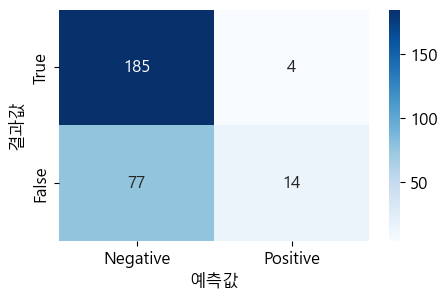

In [23]:
plt.figure(figsize=(5,3))
# 오차 행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (<https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html>)
sb.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['True', 'False'])
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

### 평가지표

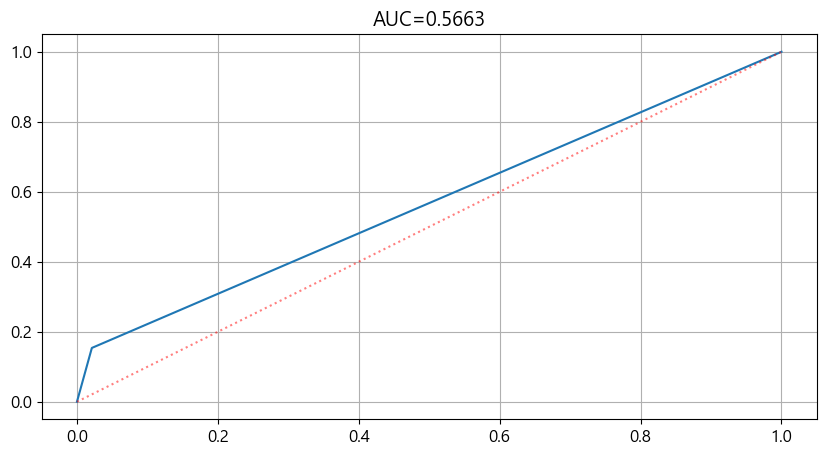

In [24]:
ras = roc_auc_score(kdf['결과값'], kdf['예측치'])

# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(kdf['결과값'], kdf['예측치'])

plt.figure()
sb.lineplot(x=fpr, y=tpr)
sb.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

> 푸른 선이 붉은 선과 멀리 떨어져야 고성능

In [25]:
# 정확도
acc = accuracy_score(kdf['결과값'], kdf['예측치'])

# 정밀도
pre = precision_score(kdf['결과값'], kdf['예측치'])

# 재현율
recall = recall_score(kdf['결과값'], kdf['예측치'])

# F1 score
f1 = f1_score(kdf['결과값'], kdf['예측치'])

# 위양성율
fallout = fp / (fp + tn)

# 특이성
spe = 1 - fallout

result_df = DataFrame({'정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})

helper.prettyPrint(result_df.T)

+--------------------------+----------+
|                          |        0 |
|--------------------------+----------|
| 정확도(Accuracy)         | 0.710714 |
| 정밀도(Precision)        | 0.777778 |
| 재현율(Recall, TPR)      | 0.153846 |
| 위양성율(Fallout, FPR)   | 0.021164 |
| 특이성(Specificity, TNR) | 0.978836 |
| RAS                      | 0.566341 |
| f1_score                 | 0.256881 |
+--------------------------+----------+


### 분류 보고서

- `precision` : 정밀도 (분류기가 참으로 분류한 항목 중에서 실제 데이터가 참인 비율)
- `recall` : 재현율 (실제 참 중에서 분류기가 참으로 분류한 비율)
- `f1-score` : 2*(Recall * Precision) / (Recall + Precision)
    - Precision과 Recall의 조화평균
    - 주로 분류 클래스 간 데이터가 심각한 불균형을 이루는 경우에 사용
    - 정확도의 경우, 클래스가 데이터 분류가 균일하지 못하면 머신의 성능을 제대로 나타내줄 수 없기 때문에 F1을 사용한다.
- `support` : 전체 데이터 수

분류 보고서 작성 시 특정 부분에서 적절하게 분류하지 못하는(학습률이 떨어지는) 경우 발생 시 해당 부분의 데이터를 보완

In [26]:
report = classification_report(kdf['결과값'], kdf['예측치'])
print(report)

              precision    recall  f1-score   support

           0       0.71      0.98      0.82       189
           1       0.78      0.15      0.26        91

    accuracy                           0.71       280
   macro avg       0.74      0.57      0.54       280
weighted avg       0.73      0.71      0.64       280

